## **Install and Import Libraries**

This section installs and imports the necessary libraries for building the image classification model, including TensorFlow for building and training the model, and other libraries for data manipulation and visualization.

In [21]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## **Load and Preprocess Data**

This section defines utility functions to handle image data. It includes a function to check for corrupted images to ensure data quality. The main part loads the images from the specified directory, extracts labels from filenames, and filters out any corrupted images before preparing them for the model.

In [8]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def is_image_corrupted(filepath):
    try:
        with Image.open(filepath) as img:
            img.verify()
        return False
    except (IOError, SyntaxError) as e:
        print(f'Corrupted image: {filepath}, error: {e}')
        return True

In [9]:
def load_data(data_dir):
    images = []
    labels = []
    
    for filename in os.listdir(data_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepath = os.path.join(data_dir, filename)
            if not is_image_corrupted(filepath):
                label = filename.split('-')[0]
                images.append(filepath)
                labels.append(label)
    
    return images, labels

image_dir = 'images/'
images, labels = load_data(image_dir)

print(f'Loaded {len(images)} images.')

Loaded 300 images.


## **Split Data and Create Data Generators**

The dataset is split into training and validation sets to evaluate the model's performance on unseen data. `ImageDataGenerator` is used to preprocess the images and apply data augmentation to the training set, which helps in preventing overfitting and improving model generalization.

In [10]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

import pandas as pd
train_df = pd.DataFrame({'filename': X_train, 'class': y_train})
val_df = pd.DataFrame({'filename': X_val, 'class': y_val})

img_size = (224, 224)
batch_size = 32

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 240 validated image filenames belonging to 2 classes.
Found 60 validated image filenames belonging to 2 classes.


## **Build the Model**

A pre-trained model, MobileNetV2, is used as the base for our classifier. The top layers of the pre-trained model are frozen, and new custom layers are added for our specific classification task. This approach, known as transfer learning, leverages the powerful features learned by the base model on a large dataset, leading to faster and more accurate training on our smaller dataset.

In [12]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)

## **Compile and Train the Model**

The model is compiled with the Adam optimizer and categorical cross-entropy loss function. It is then trained for a few epochs on the training data, and its performance is monitored on the validation set.

In [13]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 551ms/step - accuracy: 0.9083 - loss: 0.1548 - val_accuracy: 0.9667 - val_loss: 0.3894
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 424ms/step - accuracy: 0.9875 - loss: 0.0807 - val_accuracy: 0.9667 - val_loss: 0.1940
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 493ms/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 0.9667 - val_loss: 0.2277
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 554ms/step - accuracy: 0.9958 - loss: 0.0171 - val_accuracy: 0.9667 - val_loss: 0.0601
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 802ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 0.9667 - val_loss: 0.0368
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 713ms/step - accuracy: 0.9917 - loss: 0.0111 - val_accuracy: 0.9667 - val_loss: 0.1540
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 436ms/step - accuracy: 0.9875 - loss: 0.0308 - val_accuracy: 0.9667 - val_loss: 0.0871
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 362ms/step - accuracy: 0.9958 - loss: 0.0416 - val_accuracy: 0.9667 - val_loss:

## **Evaluate the Model**

The model's performance is evaluated by plotting the training and validation accuracy and loss over epochs. This helps in visualizing how well the model is learning and generalizing.

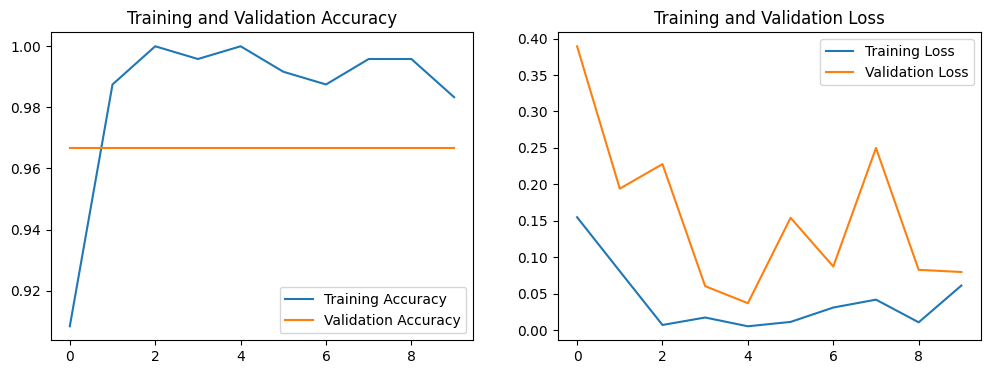

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Confusion Matrix**

A confusion matrix is generated to provide a detailed breakdown of the model's classification performance for each class. It shows the number of correct and incorrect predictions, which helps in understanding the model's strengths and weaknesses.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


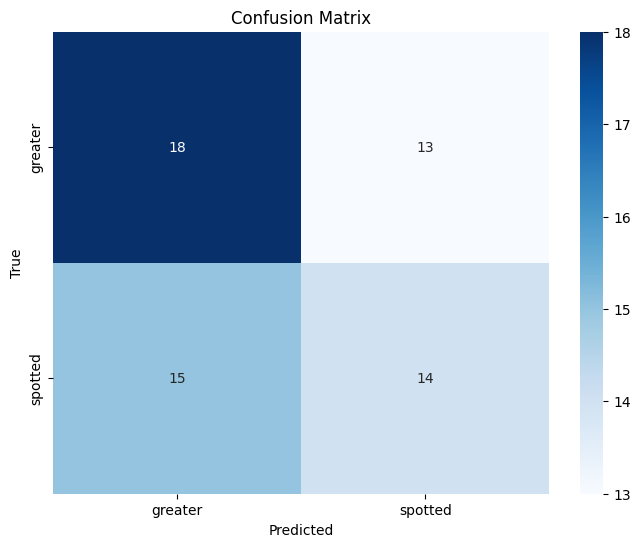

Classification Report
              precision    recall  f1-score   support

     greater       0.55      0.58      0.56        31
     spotted       0.52      0.48      0.50        29

    accuracy                           0.53        60
   macro avg       0.53      0.53      0.53        60
weighted avg       0.53      0.53      0.53        60



In [15]:
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(val_generator.classes, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print('Classification Report')
print(classification_report(val_generator.classes, y_pred, target_names=val_generator.class_indices.keys()))

**Predict on a Sample Image**

This section provides a function to predict the class of a single image. It loads an image, preprocesses it to match the model's input requirements, and then uses the trained model to make a prediction. The predicted class with the highest probability is then displayed.

In [19]:
def predict_image(filepath, model, class_indices):
    img = Image.open(filepath)
    img = img.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)

    class_labels = {v: k for k, v in class_indices.items()}
    return class_labels[predicted_class[0]]

sample_image = 'images/greater-flamingo-1.jpeg'
predicted_label = predict_image(sample_image, model, train_generator.class_indices)
print(f'The predicted label for the image is: {predicted_label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
The predicted label for the image is: greater


In [24]:
def test_random_images(model, class_indices, base_folder='images', sample_size=15):
    """
    Selects random images from all subfolders, predicts their classes,
    and prints the results.
    """
    # Collect all image paths
    image_paths = []
    for root, _, files in os.walk(base_folder):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(os.path.join(root, file))

    # Randomly sample images
    sample_paths = random.sample(image_paths, min(sample_size, len(image_paths)))

    print(f"\n🔍 Testing {len(sample_paths)} random images...\n")

    # Run predictions
    for path in sample_paths:
        predicted_label = predict_image(path, model, class_indices)
        print(f"📸 {os.path.basename(path)} → 🏷️ {predicted_label}")

    print("\n✅ Done testing random images!")


# Example usage:
test_random_images(model, train_generator.class_indices, base_folder='images', sample_size=15)


🔍 Testing 15 random images...

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
📸 spotted-eagle-65.jpeg → 🏷️ spotted
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
📸 spotted-eagle-182.jpeg → 🏷️ spotted
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
📸 spotted-eagle-70.jpeg → 🏷️ spotted
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
📸 greater-flamingo-47.jpeg → 🏷️ greater
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
📸 greater-flamingo-8.jpeg → 🏷️ greater
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
📸 greater-flamingo-9.jpeg → 🏷️ greater
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
📸 greater-flamingo-109.jpeg → 🏷️ greater
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
📸 greater-flamingo-133.jpeg → 🏷️ greater
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
📸 greater-flamingo-18.jpeg → 🏷️ greater
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
📸 spotted-eagle-103.jpeg → 🏷️ spotted
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
📸 spotted-eagle-68.jpeg → 🏷️ spotted
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
📸 greater-flamingo-103.jpeg → 🏷️ greater
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
📸 grea

**Save the Model**

The trained model, including its architecture and weights, is saved to a file. This allows for easy reuse in the future without needing to retrain. The class mappings are also saved to a JSON file for later reference.

In [17]:
model.save('artifacts/visual_classifier_2.keras')

import json
class_indices = train_generator.class_indices
class_mapping = {v: k for k, v in class_indices.items()}
with open('artifacts/class_mapping_2.json', 'w') as f:
    json.dump(class_mapping, f)